# Notebook to plot Y chromosome diversity over time

In [3]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import itertools as it
from time import time


# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on Midway Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

from python.plot_pca import *  # Import functions needed for the PCA plotting
from hapsburg.PackagesSupport.sqrt_scale import SquareRootScale

compute-e-16-235.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


In [4]:
df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v54.1.anno.haplogroups.csv") # Load Meta Data
# v53.1 Meta uses the "Y haplogroup  in ISOGG v15.73 notation (automatically called)" column

min_snp = 150000
age = [0,12000]
lat = [20,90]
lon = [-28, 180]
flag = ["_contam", "_dup"]

In [5]:
df_meta["study"]=df_meta["study"].fillna("missing")
idx = df_meta["n_cov_snp"]>min_snp
df=df_meta[idx].reset_index(drop=True)
print(f"Filtering to {np.sum(idx)}/{len(idx)} indiviuals with >{min_snp} SNPs.")
df["include"]=df["include_alt"].astype("int")

### Filtering based on Age
min_age=age[0]
idx = df["age"]>min_age
df=df[idx].reset_index(drop=True)
print(f"Filtering to {np.sum(idx)}/{len(idx)} inds >{min_age} BP.")

max_age = age[1]
idx = df["age"]<max_age
df = df[idx].reset_index(drop=True)
print(f"Filtering to {np.sum(idx)}/{len(idx)} inds <{max_age} BP.")

### Geographic Filtering
if (len(lat)>0) | (len(lon)>0):
    idx_lat = (lat[0] < df["lat"]) & (df["lat"] < lat[1])
    idx_lon = (lon[0] < df["lon"]) & (df["lon"] < lon[1])
    idx = (idx_lat & idx_lon)
    df=df[idx].reset_index(drop=True)
    print(f"Kept {np.sum(idx)}/{len(idx)} inds with matching lat/lon.")

### Flag tricky Indivdiuals
idx = df["clst"].str.contains("|".join(flag))
print(f"Kept {np.sum(~idx)}/{len(idx)} inds with good cluster labels.")
df=df[~idx].reset_index(drop=True)
df = df.sort_values(by="avg_cov_snp", ascending=False)
idx = df["Master ID"].duplicated()
print(f"Kept {np.sum(~idx)}/{len(idx)} unique Master IDs.")
df=df[~idx].reset_index(drop=True)

### Extract Males
idx= df["sex"]=="M"
print(f"Kept {np.sum(idx)}/{len(idx)} Males.")
df=df[idx].reset_index(drop=True)

Filtering to 26666/33967 indiviuals with >150000 SNPs.
Filtering to 20201/26666 inds >0 BP.
Filtering to 20113/20201 inds <12000 BP.
Kept 15371/20113 inds with matching lat/lon.
Kept 15209/15371 inds with good cluster labels.
Kept 14295/15209 unique Master IDs.
Kept 7893/14295 Males.


# Prepare Sardinia

In [6]:
df_ib = df[df["region"]=="Italy"]
df_ib["loc"].value_counts()[:50]

Campania, Naples, Herculaneum                     40
Montecilfone                                      30
Abruzzo, Peltuinum                                26
Lazio, Rieti, Corvaro                             26
Campania, San Marzano                             26
Sicily, Himera                                    23
Marche, Pesaro e Urbino, Urbino Bivio C.M.        21
Molise, Isernia, Pozzilli                         20
Campania, Eboli                                   20
Bologna, Via Orfeo Jewish Medieval Cemetery       20
Veneto, Verona, Arano                             19
Castel Sozzio                                     19
Abruzzo, Alfedena                                 16
San Marzano                                       15
Abruzzo, Presciano                                15
Piedmont, Collegno                                14
Emilia Romagna, Ceretolo, Casalecchio di Reno     14
Tortora                                           13
Sardinia, Su Crucefissu Mannu                 

# 1) Develop Code for Diversity Calculation

In [7]:
# Take everyone within 300 years of Median

def filter_df_age(df, age_delta = 300, output=False):
    """Takes Dataframe as Input, and filters to samples within age_delta of median age.
    Return Dataframe and medium Age"""
    age_med = np.median(df["age"])
    idx = (df["age"]< age_med + age_delta) & (df["age"] > age_med - age_delta)
    df = df[idx].copy().reset_index(drop=False)
    if output:
        print(f"{np.sum(idx)}/{len(idx)} IIDs within {age_delta} y of median age {age_med}")
    return df, age_med

def get_y_counts(df, digits=3, col="Y_haplo"):
    """Get Y Chromosome counts from Dataframe df"""
    ys = df[col].str[:3]
    #print(ys)
    cts = ys.value_counts().values
    return cts

def simpson_di(x):
    """ Given a count vector, returns the Simpson Diversity Index
    """
    n = np.sum(x) # Sample Size
    h = np.sum(x*(x-1)) / (n*(n-1)) # Fraction of pairs are identiclal
    s = 1 - h 
    return 1-h

def create_ydiv_df(df, sites=[], 
                   age_delta = 300, digits=3, min_m=5):
    """Take Meta Data as input, and for each site calculates
    the Simpson Index of Y chromosomes"""
    data = []
    
    for s in sites:
        df_t = df[df["loc"]==s]
        
        ### Test Data Set
        df_t, age = filter_df_age(df_t, age_delta=age_delta)
        m = len(df_t)
        
        if m >= min_m: # Only run full analysis if enough males
            y = get_y_counts(df_t)
            D = simpson_di(y)

            data.append([s, age, m, D])
          
        else:
            continue

    df = pd.DataFrame(data)
    df.columns = ["loc", "age", "males", "D"]
    return df

def get_sub_df_region(region="", min_n=5):
    """Get a Dataframe of Y haplogroup diversities per sites"""
    df_ib = df[df["region"].isin(region)]
    cts = df_ib["loc"].value_counts()
    sites = cts[cts>=min_n].index.values
    df_y_it = create_ydiv_df(df, sites=sites)
    return df_y_it

In [8]:
#df_t = df[df["loc"]=="Sardinia, Tharros"]

df_t = df[df["loc"]=="Kerkouene"]

### Test Data Set
df_t, age = filter_df_age(df_t)
y = get_y_counts(df_t)
simpson_di(y)

0.9333333333333333

In [35]:
df_y = create_ydiv_df(df, sites=["Kerkouene", "Sardinia, Tharros"])

### Group Sites from Region

In [11]:
df_y_it = get_sub_df_region(["Italy"], min_n=5)
df_y_fr = get_sub_df_region(["France", "Germany", "Austria"], min_n=5)
df_y_ib = get_sub_df_region(["Spain", "Portugal"], min_n=5)
df_y_lev = get_sub_df_region(["Israel", "Lebanon"], min_n=5)
#df_y_ib = get_sub_df_region(["Spain", "Portugal"])

df_y_pun = create_ydiv_df(df, sites=["Kerkouene", "Sardinia, Tharros", 
                                     "Sicily, Selinunte, Manuzza", "Sicily, Birgi"],
                         min_m=4)

df_y_him = create_ydiv_df(df, sites=["Sicily, Himera"],
                         min_m=4)

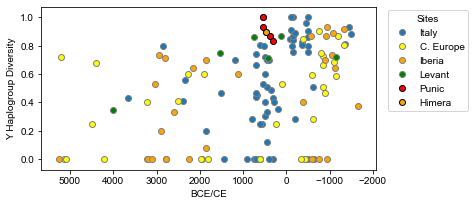

In [13]:
epsilon=0

plt.figure(figsize=(6,3))
ax = plt.gca()
ax.scatter(df_y_it["age"]-1950, df_y_it["D"]+epsilon, ec="gray", label="Italy")
ax.scatter(df_y_fr["age"]-1950, df_y_fr["D"]+epsilon, c="yellow", ec="gray", label="C. Europe")
ax.scatter(df_y_ib["age"]-1950, df_y_ib["D"]+epsilon, c="orange", ec="gray", label="Iberia")
ax.scatter(df_y_lev["age"]-1950, df_y_lev["D"]+epsilon, c="green", ec="gray", label="Levant")
ax.scatter(df_y_pun["age"]-1950, df_y_pun["D"]+epsilon, ec="k", c="red", label="Punic")
ax.scatter(df_y_him["age"]-1950, df_y_him["D"]+epsilon, ec="k", c="orange", label="Himera")

ax.set_ylabel("Y Haplogroup Diversity")
ax.set_xlabel("BCE/CE")
ax.invert_xaxis()
ax.legend(loc="upper left", title="Sites", bbox_to_anchor=(1.02, 1.01))
#ax.set_yscale('squareroot')
plt.show()

In [39]:
df[df["loc"].str.contains("Carthage")]

,iid,Master ID,loc,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,sex,Y_haplo,mtDNA_haplo,include
2737,I28504,I28504,Carthage,36.852457,10.322713,2337.0,Tunisia,Unpublished (Harald Punic),Tunisia_Punic,0.566477,679772,1.97,True,M,R1b1a1b1a,U4b1b1,1
6238,I35342,I35342,"Tunis, Carthage",36.871772,10.345020,2500.0,Tunisia,Unpublished,Tunisia_Punic,0.209397,251276,..,True,M,..,JT,1
6768,I35285,I35285,"Tunis, Carthage",36.871772,10.345020,2500.0,Tunisia,Unpublished,Tunisia_Punic_Phoenician,0.141013,169216,..,True,M,..,K1a4,1
6882,I31735,I31735,Carthage,36.871018,10.341200,2250.0,Tunisia,Unpublished,Tunisia_Punic_oAfrican,0.829924,995909,..,True,M,I2a1a1a1a1b3~,J2a2d,1
7036,I35327,I35327,"Tunis, Carthage",36.871772,10.345020,2500.0,Tunisia,Unpublished,Tunisia_Punic,0.346842,416211,..,True,M,..,T2b37,1
7246,I30451,I30451,"Carthage, Gammarth Hill",36.893377,10.313632,1650.0,Tunisia,Unpublished,Tunisia_Roman_Jewish_possible,0.441407,529688,..,True,M,E1a,L2a1c,1
7390,I35336,I35336,"Tunis, Carthage",36.871772,10.345020,2500.0,Tunisia,Unpublished,Tunisia_Punic,0.507549,609059,..,True,M,..,H5a,1
7500,I35344,I35344,"Tunis, Carthage",36.871772,10.345020,2500.0,Tunisia,Unpublished,Tunisia_Punic,0.269138,322966,..,True,M,..,V15,1
7595,I35345,I35345,"Tunis, Carthage",36.871772,10.345020,2500.0,Tunisia,Unpublished,Tunisia_Punic,0.256340,307608,..,True,M,..,H1e1,1
7613,I35343,I35343,"Tunis, Carthage",36.871772,10.345020,2500.0,Tunisia,Unpublished,Tunisia_Punic,0.394757,473708,..,True,M,..,H,1


In [ ]:
df_y_it.sort_values(by="age", ascending=False)[:50]

In [14]:
df[df["loc"].str.contains("Sicily, Himera")]

,iid,Master ID,loc,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,sex,Y_haplo,mtDNA_haplo,include
1242,I7222.SG,I7222,"Sicily, Himera",37.972296,13.824736,2430,Italy,Unpublished / Unmarked as relevant to a study ...,Italy_Sicily_Himera_480BCE_shackled.SG,0.909637,1091564,3.95474,True,M,T1a2,..,1
1316,I7223.SG,I7223,"Sicily, Himera",37.972296,13.824736,2359,Italy,Unpublished / Unmarked as relevant to a study ...,Italy_Sicily_Himera_409BCE.SG,0.910266,1092319,3.84074,True,M,J2a1a1a2b2,..,1
1389,I7221.SG,I7221,"Sicily, Himera",37.972296,13.824736,2430,Italy,Unpublished / Unmarked as relevant to a study ...,Italy_Sicily_Himera_480BCE_Greek.SG,0.905394,1086473,3.74167,True,M,G2a2a1a,..,1
1437,I7216,I7216,"Sicily, Himera",37.972296,13.824736,2430,Italy,Unpublished (Alissa Himera shackled),Italy_Sicily_Himera_480BCE_shackled,0.705132,846159,3.659086,True,M,J2a1a1a2b2a1b1~,H6b1,1
1625,I7224.SG,I7224,"Sicily, Himera",37.972296,13.824736,2359,Italy,Unpublished / Unmarked as relevant to a study ...,Italy_Sicily_Himera_409BCE.SG,0.886353,1063624,3.37545,True,M,T1a2,..,1
1639,I7219,I7219,"Sicily, Himera",37.972296,13.824736,2430,Italy,Unpublished (Alissa Himera),Italy_Sicily_Himera_480BCE_Greek,0.673923,808707,3.356759,True,M,G2a2b2a1a,J1c2,1
1670,I10950,I10950,"Sicily, Himera",37.972296,13.824736,2430,Italy,Unpublished (Alissa Himera),Italy_Sicily_Himera_480BCE_Balkan,0.584148,700977,3.306095,True,M,E1b1b1a1b1a6a~,T2b,1
1693,I10945,I10945,"Sicily, Himera",37.972296,13.824736,2430,Italy,Unpublished (Alissa Himera),Italy_Sicily_Himera_480BCE_Greek,0.584123,700948,3.267587,True,M,J2a1a1a2b1b,T2c1,1
1696,I10947,I10947,"Sicily, Himera",37.972296,13.824736,2430,Italy,Unpublished (Alissa Himera),Italy_Sicily_Himera_480BCE_Sarmatian,0.580217,696260,3.250395,True,M,R1a1a1b2a2,A6a,1
2015,I7225,I7225,"Sicily, Himera",37.972296,13.824736,2359,Italy,Unpublished (Alissa Himera),Italy_Sicily_Himera_409BCE,0.682645,819174,2.802284,True,M,R1b1a1b1a1a2b1,K1a4,1


# Area 51

In [216]:
df_y_it.sort_values(by="age", ascending=False)

,loc,age,males,D
46,"Marche, Camerano",5600.0,6,0.333333
10,"Campania, Eboli",4800.0,12,0.803030
17,"Sardinia, Su Crucefissu Mannu",4350.0,13,0.410256
24,"Sardinia, Serra Cabriles",4300.0,10,0.555556
11,"Veneto, Verona, Arano",3800.0,18,0.209150
40,"Campania, San Palolo Belsito",3450.0,7,0.523810
43,Viggiano,3400.0,6,0.000000
48,"Sardinia, Perdasdefogu, NUO, S’Orcu ‘e Tueri",3148.0,5,0.700000
36,"Lazio, Castiglione",2850.0,7,0.000000
39,"Sicily, Polizzello",2800.0,7,0.000000


In [221]:
dft = df[df["loc"].str.contains("Perdasdefogu")].sort_values(by="age")[1:]

In [222]:
dft

,iid,Master ID,loc,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,sex,Y_haplo,mtDNA_haplo,include
2954,ORC008,ORC008,"Sardinia, Perdasdefogu, NUO, S’Orcu ‘e Tueri",39.667222,9.426111,3023,Italy,MarcusNatureCommunications2020,Italy_Sardinia_BA_Nuragic,0.671400,805680,1.755544,True,M,J2b2a1,H1,1
989,I10553,I10553,"Sardinia, Perdasdefogu",39.683255,9.433333,3110,Italy,FernandesNatureEcologyEvolution2020,Italy_Sardinia_LBA,0.662355,794826,4.390819,True,M,J2b2a1,J1c2,1
3019,ORC006,ORC006,"Sardinia, Perdasdefogu, NUO, S’Orcu ‘e Tueri",39.667222,9.426111,3123,Italy,MarcusNatureCommunications2020,Italy_Sardinia_BA_Nuragic,0.643172,771806,1.682728,True,M,G2a2b2b1a1a,H1,1
2864,ORC007,ORC007,"Sardinia, Perdasdefogu, NUO, S’Orcu ‘e Tueri",39.667222,9.426111,3173,Italy,MarcusNatureCommunications2020,Italy_Sardinia_BA_Nuragic,0.689399,827279,1.835989,True,M,J2b2a1b~,H1e1a,1
2820,ORC003,ORC003,"Sardinia, Perdasdefogu, NUO, S’Orcu ‘e Tueri",39.667222,9.426111,3181,Italy,MarcusNatureCommunications2020,Italy_Sardinia_BA_Nuragic,0.691849,830219,1.877086,True,M,J2b2a1a2~,K1a4a1,1
4679,ORC004,ORC004,"Sardinia, Perdasdefogu, NUO, S’Orcu ‘e Tueri",39.667222,9.426111,3226,Italy,MarcusNatureCommunications2020,Italy_Sardinia_BA_Nuragic,0.408123,489748,0.622828,True,M,I2a1b1b,H3,1


In [175]:
df_y_ib = get_sub_df_region(["Jordania"])
df_y_ib

ValueError: Length mismatch: Expected axis has 0 elements, new values have 4 elements

In [137]:
df[df["loc"]=="Abruzzo, Alfedena"]

,iid,Master ID,loc,lat,lon,age,region,study,clst,mean_cov,n_cov_snp,avg_cov_snp,include_alt,sex,Y_haplo,mtDNA_haplo,include
785,I25120,I25120,"Abruzzo, Alfedena",41.734986,14.034655,2400,Italy,Unpublished,Italy_IA_B_son.I25091,0.589158,706990,4.785,True,M,R1b1a1b1a1a2,H+16311,1
1152,I25106,I25106,"Abruzzo, Alfedena",41.734986,14.034655,2400,Italy,Unpublished,Italy_MIA_Samnites_brother.I25083.I30605.I3061...,0.562579,675095,4.105,True,M,R1b1a1b1a1a2,V1b,1
1187,I25077,I25077,"Abruzzo, Alfedena",41.734986,14.034655,2400,Italy,Unpublished,Italy_IA_B,0.643566,772279,4.048,True,M,R1b1a1b1a1a2,H2,1
1253,I25136,I25136,"Abruzzo, Alfedena",41.734986,14.034655,2400,Italy,Unpublished,Italy_MIA_Samnites_brother.I25095,0.592750,711300,3.938,True,M,R1b1a1b1a1a2,H1e,1
1474,I25083,I25083,"Abruzzo, Alfedena",41.734986,14.034655,2400,Italy,Unpublished,Italy_MIA_Samnites_brother.I25106.I30605.I3061...,0.666302,799562,3.605,True,M,R1b1a1b1a1a2,V1b,1
1738,I25121,I25121,"Abruzzo, Alfedena",41.734986,14.034655,2400,Italy,Unpublished,Italy_IA_B,0.578878,694654,3.201,True,M,R1b1a1b1a1a2,K2a5b,1
2239,I25126,I25126,"Abruzzo, Alfedena",41.734986,14.034655,2400,Italy,Unpublished,Italy_IA_B,0.503507,604208,2.477,True,M,R1b1a1b1a1a2,U1a1a,1
2314,I25117,I25117,"Abruzzo, Alfedena",41.734986,14.034655,2400,Italy,Unpublished,Italy_IA_B,0.525578,630694,2.397,True,M,R1b1a1b1a1a2,K2b1,1
2443,I25108,I25108,"Abruzzo, Alfedena",41.734986,14.034655,2400,Italy,Unpublished,Italy_IA_B,0.555635,666762,2.244,True,M,R1b1a1b1a1a2,HV0+195,1
